In [27]:
# === Point-Fraction Silhouettes from 3D Points (2 states) ===
# Inputs: two CSVs with ['middle_x','middle_y','middle_z']
# Outputs (in out_dir):
#    - proj_XY.png, proj_YZ.png, proj_XZ.png
#    - overlay_[PLANE]_pXX_pointfrac.png          (XX in e.g. 100,95,90,80,60,50)
#    - metrics_pointfrac.csv  (variant='point_fraction', plus IoU/meanNN/Hausdorff)
#    - meta_pointfrac.json
#
# Notes:
#    - frac_levels are **point fractions** (1.0 == 100% of points)
#    - We rank points by KDE (local crowding), keep the top ceil(frac*N) points,
#      rasterize them, clean the mask, then extract the main contour.
#    - Grid bounds/scale match across A/B via a shared 3D bbox (like HDR pipeline).


import os, json, math, itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Tuple, Dict, List, Optional

from scipy.ndimage import binary_closing, binary_opening, label, binary_fill_holes
from scipy.spatial import cKDTree
from skimage.measure import find_contours
from sklearn.neighbors import KernelDensity
from scipy.spatial.distance import pdist

np.set_printoptions(suppress=True)

# ------------------ Shared utilities ------------------

PLANE_FROM_AXIS = {'z': 'XY', 'y': 'XZ', 'x': 'YZ'}  # drop axis -> plane name
AXPAIR = {'z': (0,1), 'x': (1,2), 'y': (0,2)}      # which coords to project

def load_points(csv: str) -> np.ndarray:
    df = pd.read_csv(csv)
    P = df[["middle_x","middle_y","middle_z"]].dropna().values.astype(np.float32)
    if len(P) < 50:
        raise ValueError(f"Too few points in {csv}")
    return P

def save_point_projection_like_screenshot(A, B, i, j, plane, out_dir,
                                          labelA="A", labelB="B"):
    all2 = np.vstack([A[:,[i,j]], B[:,[i,j]]])
    (xmin,ymin) = all2.min(0); (xmax,ymax) = all2.max(0)
    xr, yr = (xmax-xmin), (ymax-ymin); pad = 0.02
    fig, ax = plt.subplots(figsize=(5,4))
    ax.set_facecolor("#f0f0f0")
    ax.scatter(A[:, i], A[:, j], marker="+", s=8, linewidths=0.6,
               alpha=0.85, c="#1f77b4", label=labelA)
    ax.scatter(B[:, i], B[:, j], marker="x", s=8, linewidths=0.6,
               alpha=0.75, c="#d62728", label=labelB)
    ax.set_xlim(xmin - pad*xr, xmax + pad*xr)
    ax.set_ylim(ymin - pad*yr, ymax + pad*yr)
    ax.set_aspect("equal","box"); ax.set_xticks([]); ax.set_yticks([])
    ax.set_title(plane); ax.legend(loc="upper left", fontsize=8, frameon=True)
    os.makedirs(out_dir, exist_ok=True)
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"proj_{plane}.png"), dpi=200, bbox_inches="tight")
    plt.close(fig)

def iou_bool(A: np.ndarray, B: np.ndarray) -> float:
    inter = np.logical_and(A,B).sum()
    union = np.logical_or(A,B).sum()
    return float(inter) / float(union + 1e-9)

def contour_from_bool(M: np.ndarray) -> Optional[np.ndarray]:
    if M is None or M.sum() == 0: return None
    cs = find_contours(M.astype(float), level=0.5)
    if not cs: return None
    cs.sort(key=lambda c: c.shape[0], reverse=True)
    return cs[0]

def contour_distances(CA: Optional[np.ndarray], CB: Optional[np.ndarray]) -> Tuple[float,float]:
    """Mean NN distance and (max) Hausdorff between two polylines (pixel units)."""
    if CA is None or CB is None: return float('nan'), float('nan')
    TA, TB = cKDTree(CA), cKDTree(CB)  # coordinates are [row,col]
    da,_ = TA.query(CB, k=1); db,_ = TB.query(CA, k=1)
    return float((da.mean()+db.mean())/2.0), float(max(da.max(), db.max()))

def pca_axes(pts: np.ndarray):
    C = np.cov((pts - pts.mean(0)).T)
    w, V = np.linalg.eigh(C)
    V = V[:, np.argsort(w)[::-1]]
    if np.linalg.det(V) < 0:
        V[:, -1] *= -1
    return V

def nn_metrics(A_pts, B_pts):
    ta, tb = cKDTree(A_pts), cKDTree(B_pts)
    dBA,_ = ta.query(B_pts, k=1); dAB,_ = tb.query(A_pts, k=1)
    rmse = float(np.sqrt((np.concatenate([dBA, dAB])**2).mean()))
    return rmse

def best_pca_prealign(B_pts, A_pts):
    Va, Vb = pca_axes(A_pts), pca_axes(B_pts)
    perms = list(itertools.permutations(range(3)))
    signs = list(itertools.product([1,-1], repeat=3))
    best_R, best_rmse = np.eye(3), np.inf
    for p in perms:
        Pm = np.zeros((3,3)); Pm[range(3), list(p)] = 1
        for s in signs:
            S = np.diag(s)
            R = Va @ (Pm @ S) @ Vb.T
            rmse = nn_metrics(A_pts, B_pts @ R.T)
            if rmse < best_rmse:
                best_rmse, best_R = rmse, R
    return best_R

def kabsch(P, Q):
    Pc, Qc = P.mean(0), Q.mean(0)
    P0, Q0 = P - Pc, Q - Qc
    H = Q0.T @ P0
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T
    if np.linalg.det(R) < 0:
        Vt[-1,:] *= -1; R = Vt.T @ U.T
    t = Pc - Qc @ R.T
    return R, t

def icp_rigid_robust(A_pts, B_pts, iters=30, sample=50000, trim_q=0.10, seed=11):
    rs = np.random.default_rng(seed)
    A = A_pts if len(A_pts)<=sample else A_pts[rs.choice(len(A_pts), sample, replace=False)]
    B = B_pts if len(B_pts)<=sample else B_pts[rs.choice(len(B_pts), sample, replace=False)]
    R, t = np.eye(3), np.zeros(3)
    for _ in range(iters):
        Bx = B @ R.T + t
        tree = cKDTree(A); d, idx = tree.query(Bx, k=1)
        P = A[idx]
        if 0.0 < trim_q < 0.5:
            thr = np.quantile(d, 1 - trim_q)
            keep = d <= thr
            P, Bx = P[keep], Bx[keep]
        R_upd, t_upd = kabsch(P, Bx)
        R = R_upd @ R
        t = (t @ R_upd.T) + t_upd
    return R, t

def make_grid_from_bounds(P: np.ndarray, base=160, pad_frac=0.05):
    mn, mx = P.min(0), P.max(0)
    ext = mx - mn
    pad = pad_frac * float(ext.max()); mn -= pad; mx += pad; ext = mx - mn
    scale = base / float(ext.max() + 1e-8)
    dims = np.clip(np.ceil(ext * scale).astype(int), 32, 512)
    edges = [np.linspace(mn[i], mx[i], dims[i] + 1, dtype=np.float32) for i in range(3)]
    return edges, dims

# ------------------ Point-fraction core ------------------

def project_plane(P: np.ndarray, axis: str) -> np.ndarray:
    d = {'x': [1,2], 'y': [0,2], 'z': [0,1]}[axis]
    return P[:, d]

def kde_scores(points2d: np.ndarray, bandwidth: float) -> np.ndarray:
    """Gaussian KDE score per point (log-density up to constant)."""
    if points2d.shape[0] < 2:
        return np.zeros(points2d.shape[0])
    kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
    kde.fit(points2d)
    return kde.score_samples(points2d)

def auto_bandwidth(points2d: np.ndarray) -> float:
    N = points2d.shape[0]
    if N <= 1:
        return 1.0
    if N > 500:
        idx = np.random.choice(N, size=500, replace=False)
        samp = points2d[idx]
    else:
        samp = points2d
    md = np.median(pdist(samp)) if samp.shape[0] >= 2 else 1.0
    return max(1e-6, md * 0.5)

def rasterize_points(points2d: np.ndarray, xs, ys, disk_px=2) -> np.ndarray:
    """Rasterize points to a binary mask with small disks (radius=disk_px pixels)."""
    ny, nx = len(ys), len(xs)
    img = np.zeros((ny, nx), dtype=bool)
    rr = np.arange(-disk_px, disk_px+1)
    XX, YY = np.meshgrid(rr, rr, indexing='xy')
    disk = (XX**2 + YY**2) <= (disk_px**2)
    dh, dw = disk.shape[0]//2, disk.shape[1]//2
    x_idx = np.clip(np.searchsorted(xs, points2d[:,0]) - 1, 0, nx-1)
    y_idx = np.clip(np.searchsorted(ys, points2d[:,1]) - 1, 0, ny-1)
    for y, x in zip(y_idx, x_idx):
        y0, y1 = max(0, y-dh), min(ny, y+dh+1)
        x0, x1 = max(0, x-dw), min(nx, x+dw+1)
        dy0 = 0 if y0==y-dh else (y-dh - y0)
        dx0 = 0 if x0==x-dw else (x-dw - x0)
        img[y0:y1, x0:x1] |= disk[dy0:dy0+(y1-y0), dx0:dx0+(x1-x0)]
    return img

def biggest_component_mask(mask: np.ndarray) -> np.ndarray:
    """
    Cleans a binary mask by keeping only the largest connected component and filling any holes in it.
    This produces a solid silhouette.
    """
    if mask.sum() == 0:
        return mask

    labeled_mask, num_features = label(mask)
    if num_features == 0:
        return mask

    component_sizes = np.bincount(labeled_mask.ravel())
    if len(component_sizes) <= 1: # Only background found
        return np.zeros_like(mask)

    # Ignore component 0 (background)
    largest_component_label = np.argmax(component_sizes[1:]) + 1
    largest_component = (labeled_mask == largest_component_label)
    solid_mask = binary_fill_holes(largest_component)
    return solid_mask

def point_fraction_mask(points2d: np.ndarray,
                        xs, ys,
                        frac: float,
                        bandwidth: Optional[float],
                        disk_px: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Binary mask enclosing the top ceil(frac*N) points by local density.
    Returns (mask, kept_points2d).
    """
    N = points2d.shape[0]
    k = max(1, int(math.ceil(frac * N)))
    bw = auto_bandwidth(points2d) if bandwidth is None else bandwidth
    scores = kde_scores(points2d, bandwidth=bw)
    order = np.argsort(scores)[::-1]
    keep_idx = order[:k]
    kept = points2d[keep_idx]
    
    mask = rasterize_points(kept, xs, ys, disk_px=disk_px)
    mask = binary_closing(mask, iterations=1)
    mask = binary_opening(mask, iterations=1)
    mask = biggest_component_mask(mask)
    return mask, kept

def point_fraction_contour(points2d: np.ndarray,
                           xs, ys,
                           frac: float,
                           bandwidth: Optional[float],
                           disk_px: int) -> Tuple[Optional[np.ndarray], np.ndarray, np.ndarray]:
    mask, kept = point_fraction_mask(points2d, xs, ys, frac, bandwidth, disk_px)
    C = contour_from_bool(mask)
    return C, mask, kept

def save_overlay_pointfrac_level(background_mask, MA, CA, MB, CB, frac, axis, out_dir, labelA, labelB):
    plane = PLANE_FROM_AXIS[axis]
    fig, ax = plt.subplots(figsize=(5.2, 5.2))
    
    ax.imshow(background_mask, cmap="gray", alpha=0.12)

    if CA is not None:
        ax.plot(CA[:,1], CA[:,0], '-', lw=2.4, color="#1f77b4", alpha=0.95,
                label=f"{labelA} point {int(round(frac*100))}%")
    if CB is not None:
        ax.plot(CB[:,1], CB[:,0], '-', lw=2.4, color="#d62728", alpha=0.95,
                label=f"{labelB} point {int(round(frac*100))}%")
    ax.set_title(f"{plane} — point-fraction {int(round(frac*100))}%")
    ax.set_axis_off(); ax.legend(frameon=False, loc="upper right")
    os.makedirs(out_dir, exist_ok=True)
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"overlay_{plane}_p{int(round(frac*100))}_pointfrac.png"),
                dpi=220, bbox_inches="tight")
    plt.close(fig)

# ------------------ Config + Runner ------------------

@dataclass
class CfgPF:
    grid_base:   int   = 160
    pad_frac:    float = 0.05
    frac_levels: Tuple[float, ...] = (1.00, 0.95, 0.90, 0.80, 0.60, 0.50)
    disk_px:     int   = 2
    bandwidth:   Optional[float] = None
    trim_q:      float = 0.10
    icp_iters:   int   = 30
    sample_icp:  int   = 50000
    out_dir:     str   = "out_point_fraction_2state"

def run_point_fraction(csv_A: str, csv_B: str, cfg=CfgPF(),
                       labelA="A", labelB="B"):
    os.makedirs(cfg.out_dir, exist_ok=True)

    A_raw, B_raw = load_points(csv_A), load_points(csv_B)
    A0, B0 = A_raw - A_raw.mean(0), B_raw - B_raw.mean(0)

    Rpre = best_pca_prealign(B0, A0); B1 = B0 @ Rpre.T
    Ricp, ticp = icp_rigid_robust(A0, B1, iters=cfg.icp_iters,
                                  sample=cfg.sample_icp, trim_q=cfg.trim_q)
    A_al, B_al = A0, (B1 @ Ricp.T + ticp)

    mins = np.vstack([A_al, B_al]).min(0); maxs = np.vstack([A_al, B_al]).max(0)
    s = float((maxs - mins).max()); A = A_al/s; B = B_al/s

    edges3d, dims3d = make_grid_from_bounds(np.vstack([A, B]),
                                            base=cfg.grid_base, pad_frac=cfg.pad_frac)

    save_point_projection_like_screenshot(A, B, 0, 1, "XY", cfg.out_dir, labelA, labelB)
    save_point_projection_like_screenshot(A, B, 1, 2, "YZ", cfg.out_dir, labelA, labelB)
    save_point_projection_like_screenshot(A, B, 0, 2, "XZ", cfg.out_dir, labelA, labelB)

    metrics_rows = []
    for a in ('x','y','z'):
        plane = PLANE_FROM_AXIS[a]
        i, j = AXPAIR[a]
        ex = edges3d[i]; ey = edges3d[j]
        nx = len(ex) - 1; ny = len(ey) - 1
        xs = np.linspace(ex[0], ex[-1], nx)
        ys = np.linspace(ey[0], ey[-1], ny)

        A2 = A[:, [i, j]]
        B2 = B[:, [i, j]]
        
        # --- ROBUST BACKGROUND GENERATION ---
        # 1. Rasterize all points for each set
        full_mask_A_raw = rasterize_points(A2, xs, ys, disk_px=cfg.disk_px)
        full_mask_B_raw = rasterize_points(B2, xs, ys, disk_px=cfg.disk_px)
        
        # 2. Clean each mask individually using the full, robust process
        clean_mask_A = biggest_component_mask(binary_opening(binary_closing(full_mask_A_raw)))
        clean_mask_B = biggest_component_mask(binary_opening(binary_closing(full_mask_B_raw)))
        
        # 3. Combine them for the final background silhouette
        background_silhouette = np.logical_or(clean_mask_A, clean_mask_B)

        for frac in cfg.frac_levels:
            CA, MA, keptA = point_fraction_contour(A2, xs, ys, frac,
                                                   bandwidth=cfg.bandwidth,
                                                   disk_px=cfg.disk_px)
            CB, MB, keptB = point_fraction_contour(B2, xs, ys, frac,
                                                   bandwidth=cfg.bandwidth,
                                                   disk_px=cfg.disk_px)

            save_overlay_pointfrac_level(background_silhouette, MA, CA, MB, CB, frac, a, cfg.out_dir, labelA, labelB)

            IoU = iou_bool(MA, MB)
            mnn, haus = contour_distances(CA, CB)
            metrics_rows.append(dict(
                plane=plane, level=int(round(frac*100)), variant="point_fraction",
                IoU=IoU, meanNN=mnn, Hausdorff=haus,
                keptA=int(len(keptA)), keptB=int(len(keptB))
            ))

    df = pd.DataFrame(metrics_rows).sort_values(["plane","level"], ascending=[True, False])
    df.to_csv(os.path.join(cfg.out_dir, "metrics_pointfrac.csv"), index=False)

    meta = dict(csv_A=csv_A, csv_B=csv_B,
                label_A=labelA, label_B=labelB,
                cfg=cfg.__dict__,
                note="Per-plane silhouettes enclosing a chosen fraction of points (densest ceil(frac*N) by KDE); PCA+ICP-aligned & shared bbox; masks rasterized and cleaned; main component contoured.")
    with open(os.path.join(cfg.out_dir, "meta_pointfrac.json"), "w") as f:
        json.dump(meta, f, indent=2)

    print(df)
    print(f"[PointFraction] Saved overlays & metrics in: {cfg.out_dir}")

# ------------------ Example run ------------------

if __name__ == "__main__":
    LABEL_A = "12 h — UNTR"
    LABEL_B = "12 h — VACV"
    CSV_A = "data/green_monkey/all_structure_files/chr1/12hrs/untr/structure_12hrs_untr_gene_info.csv"
    CSV_B = "data/green_monkey/all_structure_files/chr1/12hrs/vacv/structure_12hrs_vacv_gene_info.csv"

    # Create dummy files for demonstration if they don't exist
    for d in [os.path.dirname(CSV_A), os.path.dirname(CSV_B)]:
        os.makedirs(d, exist_ok=True)
    if not os.path.exists(CSV_A):
        print(f"Creating dummy file for CSV_A: {CSV_A}")
        dummy_data_A = pd.DataFrame(np.random.rand(200, 3) * 100, columns=["middle_x", "middle_y", "middle_z"])
        dummy_data_A.to_csv(CSV_A, index=False)
    if not os.path.exists(CSV_B):
        print(f"Creating dummy file for CSV_B: {CSV_B}")
        dummy_data_B = pd.DataFrame(np.random.rand(200, 3) * 100 + 20, columns=["middle_x", "middle_y", "middle_z"])
        dummy_data_B.to_csv(CSV_B, index=False)

    run_point_fraction(
        CSV_A, CSV_B,
        CfgPF(
            grid_base=160, pad_frac=0.05,
            frac_levels=(1.00, 0.95, 0.90, 0.80, 0.60, 0.50),
            disk_px=2,
            bandwidth=None,
            trim_q=0.10, icp_iters=30, sample_icp=50000,
            out_dir="data/green_monkey/va_testing/out_pointfrac_modified"
        ),
        labelA=LABEL_A, labelB=LABEL_B
    )

   plane  level         variant       IoU    meanNN  Hausdorff  keptA  keptB
12    XY    100  point_fraction  0.722209  4.758943  21.931712   1931   1931
13    XY     95  point_fraction  0.695160  5.237973  21.931712   1835   1835
14    XY     90  point_fraction  0.671989  5.520097  17.804494   1738   1738
15    XY     80  point_fraction  0.666778  5.223887  16.552945   1545   1545
16    XY     60  point_fraction  0.688383  4.544898  16.643317   1159   1159
17    XY     50  point_fraction  0.706547  4.103443  15.231546    966    966
6     XZ    100  point_fraction  0.622609  5.244961  20.024984   1931   1931
7     XZ     95  point_fraction  0.572795  5.944861  22.627417   1835   1835
8     XZ     90  point_fraction  0.540396  6.598640  26.076810   1738   1738
9     XZ     80  point_fraction  0.520123  6.304864  25.942244   1545   1545
10    XZ     60  point_fraction  0.467317  6.592350  26.248809   1159   1159
11    XZ     50  point_fraction  0.438885  6.728437  25.495098    966    966

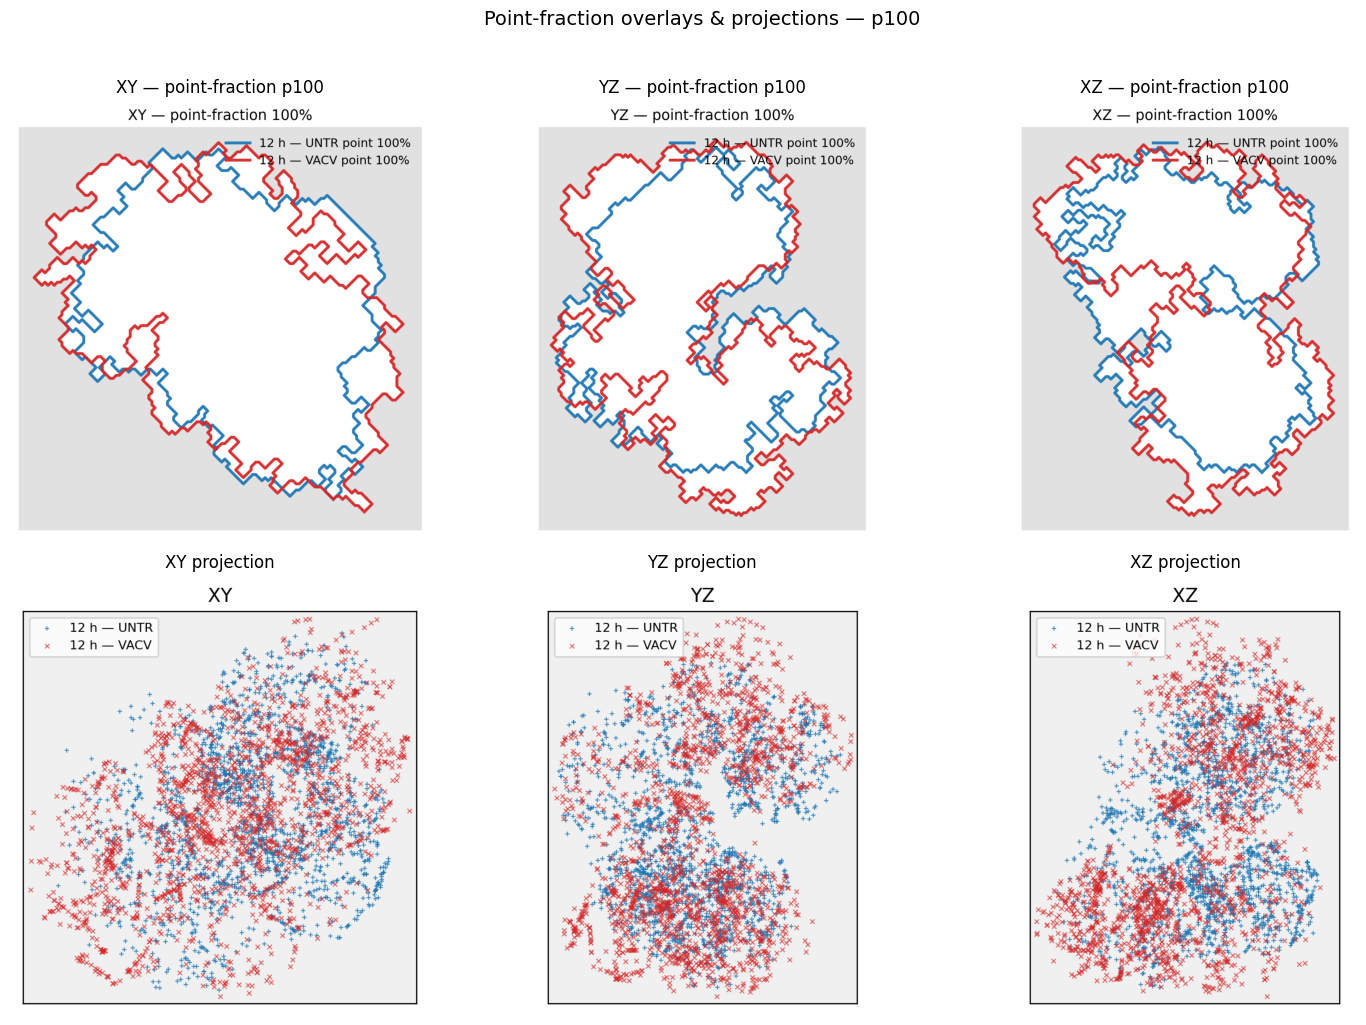

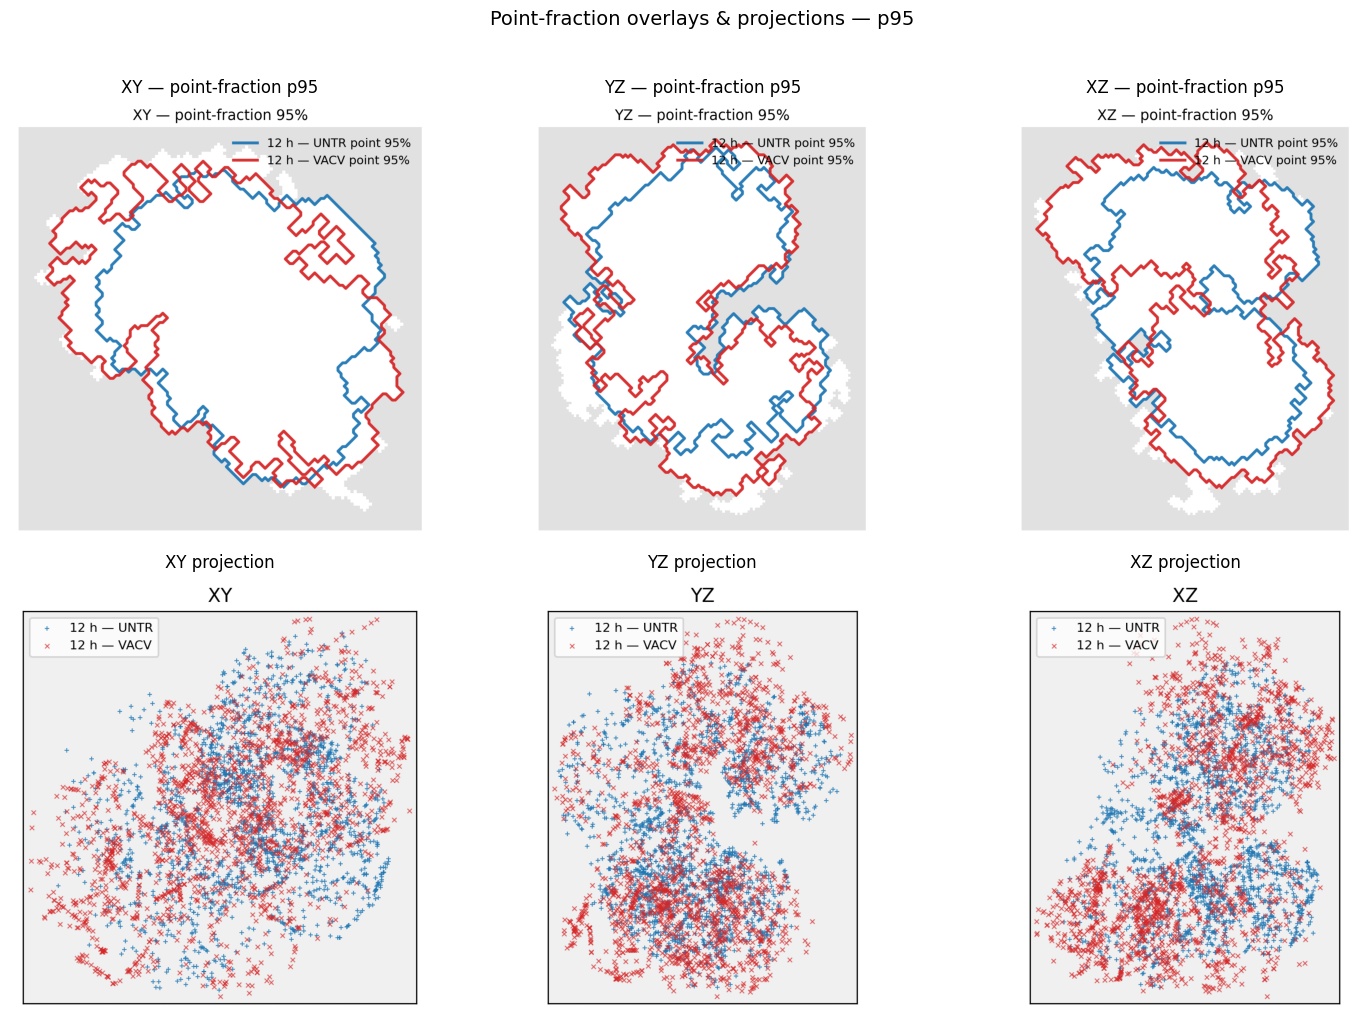

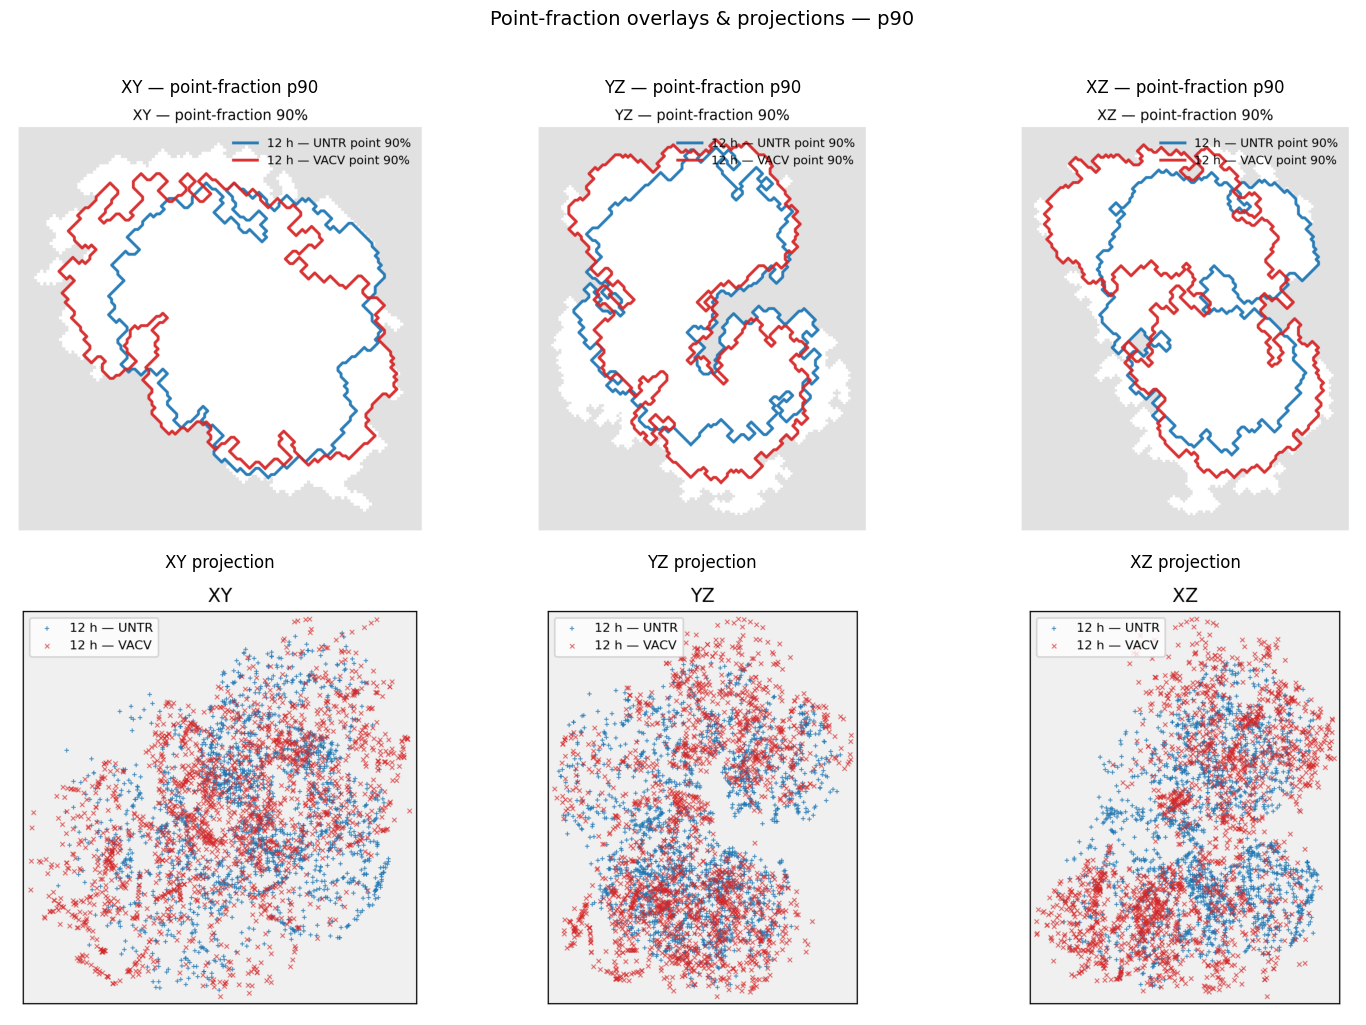

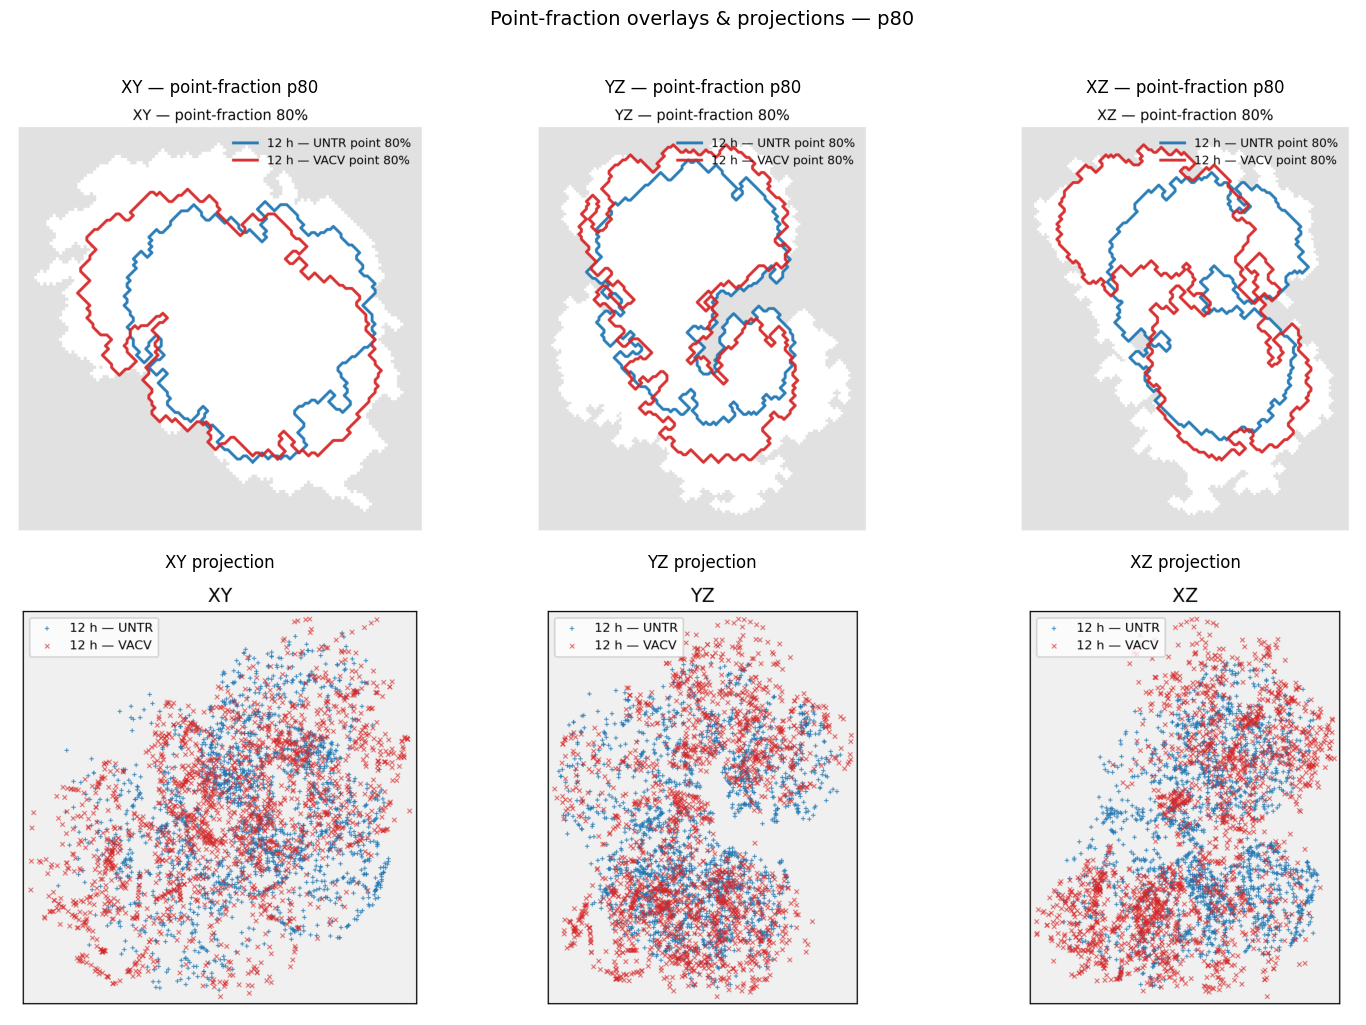

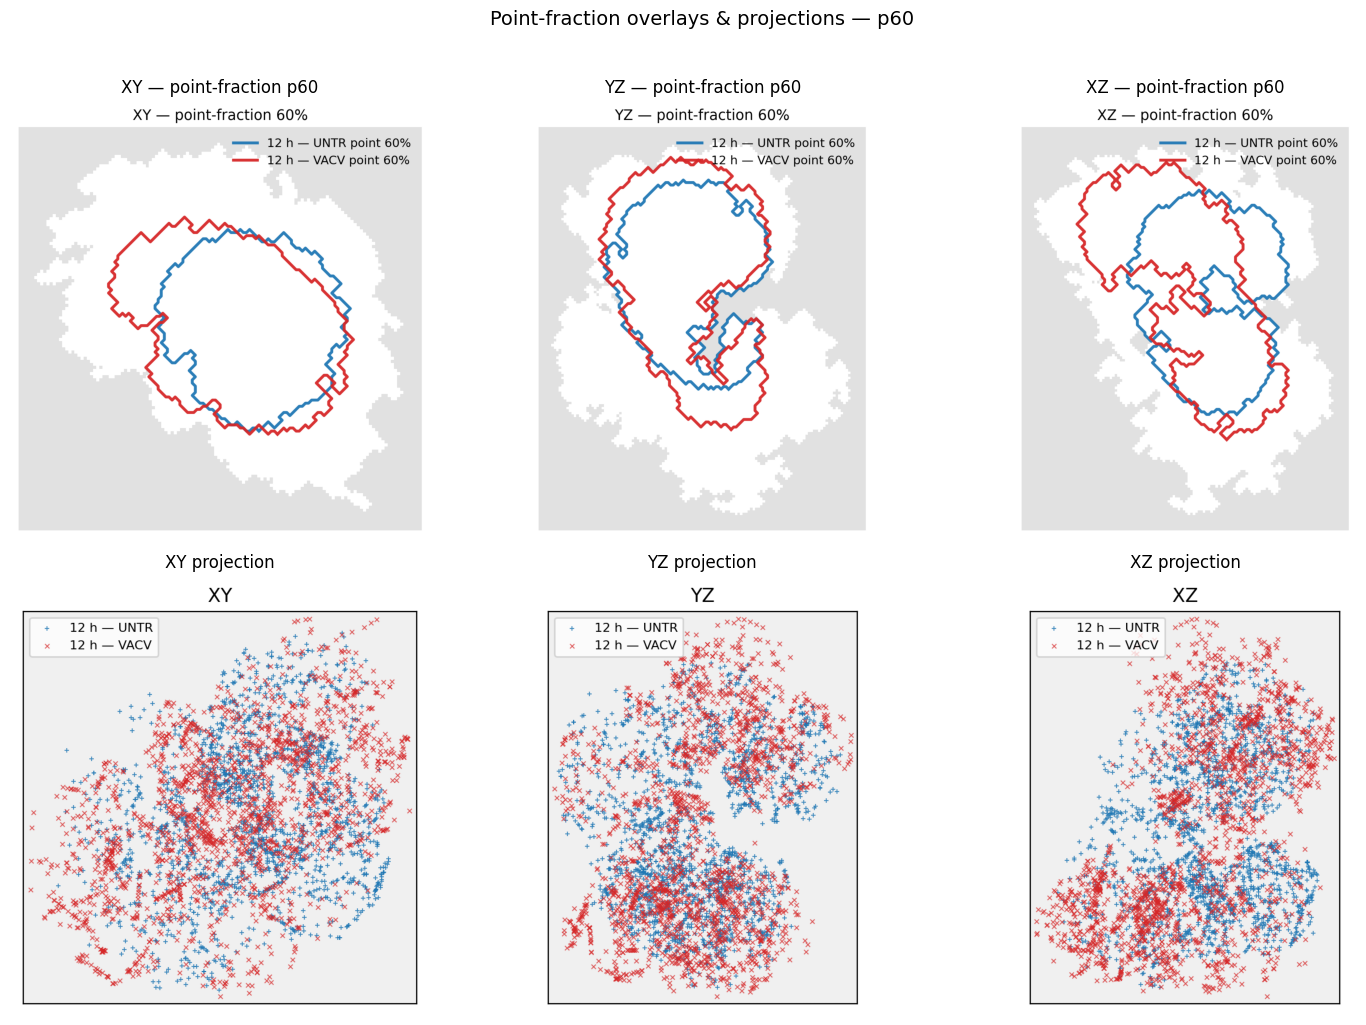

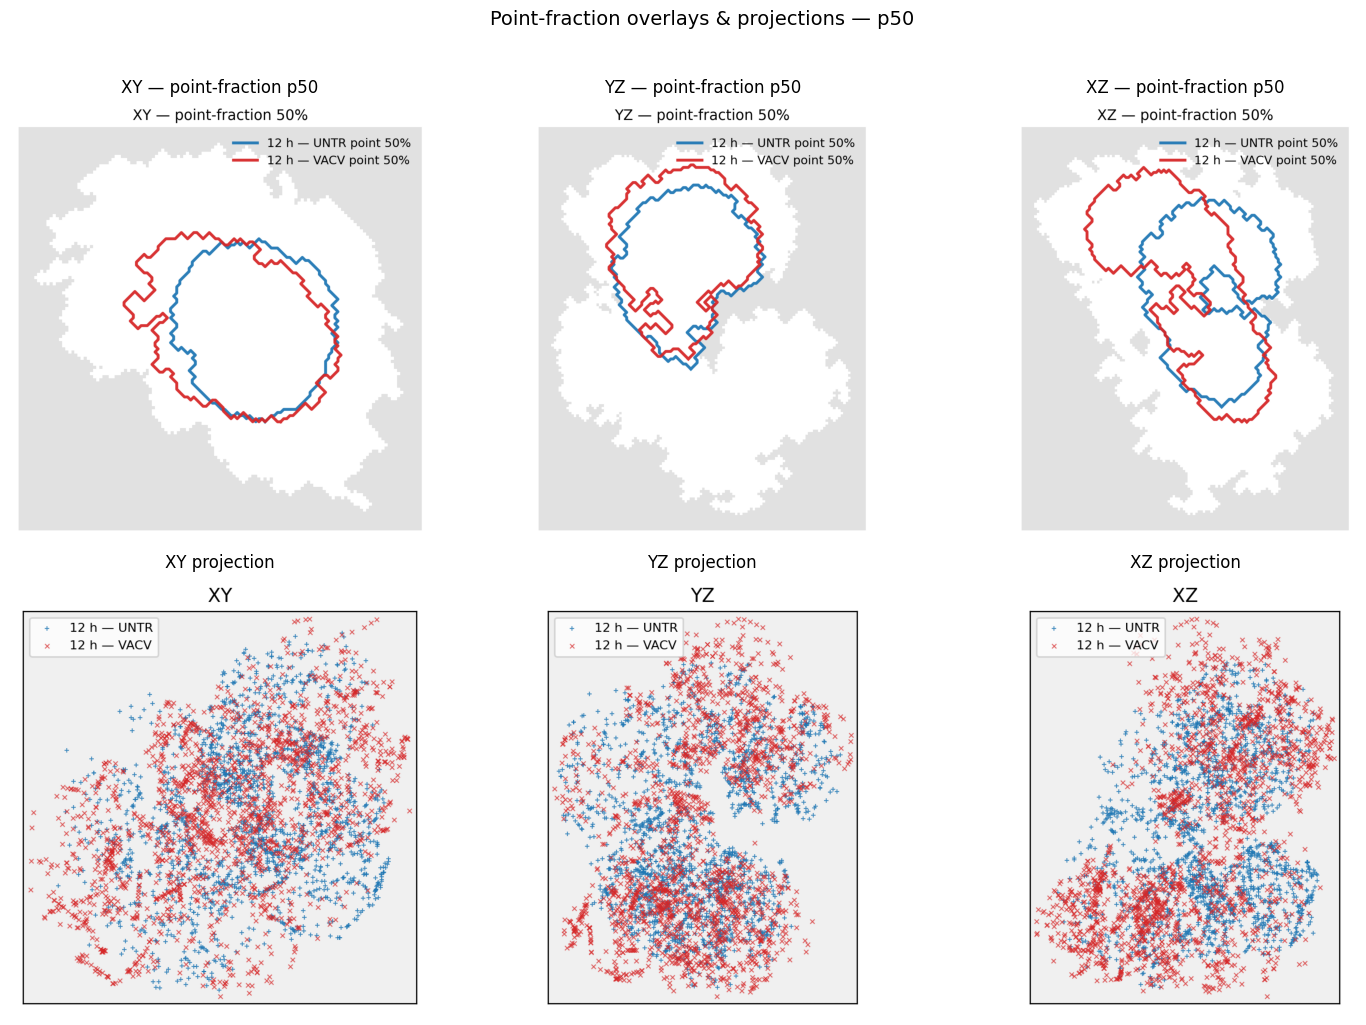

In [28]:
import os, numpy as np, matplotlib.pyplot as plt, matplotlib.image as mpimg

OUT_PF = "data/green_monkey/va_testing/out_pointfrac_modified"  # point-fraction out_dir

def show_pointfrac_and_projections(levels=(1.00, 0.95, 0.90, 0.80, 0.60, 0.50),
                                   planes=("XY","YZ","XZ"),
                                   out_dir=OUT_PF,
                                   save=False,
                                   save_dir=None,
                                   dpi=180):
    """
    For each level in `levels`, show a panel:
      Row 1: overlay_<PLANE>_pXX_pointfrac.png  (per-level point-fraction contour for A vs B)
      Row 2: proj_<PLANE>.png                   (point projection)
    """
    for p in levels:
        p_int = int(round(p*100))
        ptag = f"p{p_int}"

        nrows = 2
        fig, axs = plt.subplots(nrows, len(planes), figsize=(15, 10))

        # handle 1D/2D axes consistently
        if nrows == 1:
            axs = np.array([axs])
        if axs.ndim == 1:
            axs = axs[None, :]

        # --- Row 1: point-fraction overlays ---
        for col, plane in enumerate(planes):
            ax = axs[0, col]
            overlay_path = os.path.join(out_dir, f"overlay_{plane}_{ptag}_pointfrac.png")
            if os.path.exists(overlay_path):
                ax.imshow(mpimg.imread(overlay_path))
                ax.set_title(f"{plane} — point-fraction {ptag}", fontsize=12)
            else:
                ax.text(0.5, 0.5, f"Missing overlay_{plane}_{ptag}_pointfrac.png",
                        ha="center", va="center")
            ax.axis("off")

        # --- Row 2: point projections ---
        for col, plane in enumerate(planes):
            ax = axs[1, col]
            proj_path = os.path.join(out_dir, f"proj_{plane}.png")
            if os.path.exists(proj_path):
                ax.imshow(mpimg.imread(proj_path))
                ax.set_title(f"{plane} projection", fontsize=12)
            else:
                ax.text(0.5, 0.5, f"Missing proj_{plane}.png",
                        ha="center", va="center")
            ax.axis("off")

        plt.suptitle(f"Point-fraction overlays & projections — {ptag}", y=1.02, fontsize=14)
        plt.tight_layout()

        if save:
            os.makedirs(save_dir or out_dir, exist_ok=True)
            out_png = os.path.join(save_dir or out_dir, f"panel_{ptag}_pointfrac.png")
            plt.savefig(out_png, dpi=dpi, bbox_inches="tight")
        plt.show()

# quick view
show_pointfrac_and_projections(
    levels=(1.00, 0.95, 0.90, 0.80, 0.60, 0.50),
    planes=("XY","YZ","XZ"),
    out_dir=OUT_PF,
    save=False
)
